# NeuralSDE

In [22]:
from diffusion_policy.dataset.pusht_image_dataset import PushTImageDataset
from data_utils import EpisodeDataset
import functools
from tqdm import tqdm
import torch
import numpy as np
from utils import (
    denormalize_img,
    denormalize_pn1,
    denormalize_standard_normal,
    normalize_img,
    normalize_pn1,
    normalize_standard_normal,
    plot_losses,
)
dataset_path='/home/matteogu/ssd_data/data_diffusion/pusht/pusht_cchi_v7_replay.zarr'

dataset = PushTImageDataset(dataset_path)
full_dataset = torch.from_numpy(dataset.replay_buffer["img"]).permute(0, 3, 1, 2)
N, C, H, W = full_dataset.shape

# Make the state normalizer.
max_state = dataset.replay_buffer["state"].max(axis=0)
min_state = dataset.replay_buffer["state"].min(axis=0)

STATE_DIM = 5

state_normalizer = functools.partial(
    normalize_pn1, min_val=min_state, max_val=max_state
)

process_fns = {"state": state_normalizer} 
obs_key="state"

# n_obs_history = 1
print("Making datasets and dataloaders.")
dataset_params = {'n_obs_history': n_obs_history,
                  'n_pred_horizon': n_pred_horizon,
                  'include_keys': include_keys,
                  'process_fns': process_fns,
                  'device': device}

# Make the episode dataset and create a DataLoader.
train_episode_dataset = EpisodeDataset(dataset, episode_idxs=train_idxs, **dataset_params)
val_episode_dataset = EpisodeDataset(dataset, episode_idxs=val_idxs, **dataset_params)


Making datasets and dataloaders.


NameError: name 'n_obs_history' is not defined

In [29]:
dataset.replay_buffer["state"].shape

dataset.episode_idxs = range(dataset.replay_buffer.n_episodes)
EPISODES = []
for episode_idx in tqdm(dataset.episode_idxs, desc="Preparing data"):
    episode = dataset.replay_buffer.get_episode(episode_idx)
    print(episode['state'].shape)
    EPISODES.append(episode['state'])
    EPISODES.append(np.zeros((50,5)))
    # print(episode)
    if episode_idx > 3:
        break

Preparing data:   2%|▏         | 4/206 [00:00<00:00, 41630.81it/s]

(161, 5)
(118, 5)
(141, 5)
(159, 5)
(159, 5)


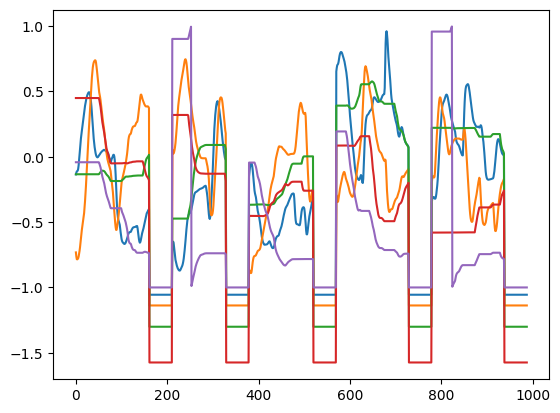

In [30]:

plt.plot(state_normalizer(np.vstack(EPISODES)))

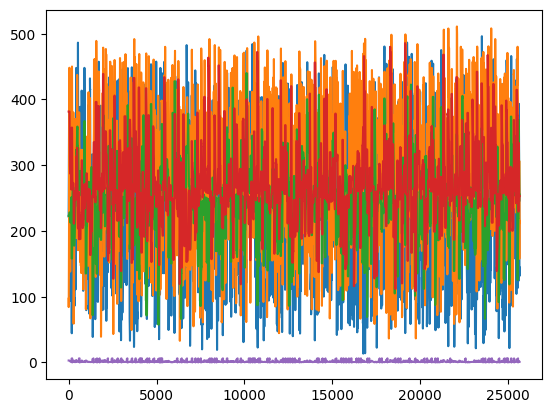

In [6]:
import matplotlib.pyplot as plt 
plt.plot(dataset.replay_buffer["state"])

# Neural ODE

In [2]:
import collections
import copy
import datetime
import functools
import math
import os
import sys
import time
from typing import Callable, Optional

if "PyTorch_VAE" not in sys.path:
    sys.path.append("PyTorch_VAE")

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from tqdm.notebook import tqdm, trange

import wandb
from diffusion_policy.common.pytorch_util import compute_conv_output_shape
# from diffusion_policy.common.sampler import get_val_mask
from diffusion_policy.dataset.pusht_image_dataset import PushTImageDataset
from diffusion_policy.model.diffusion import conditional_unet1d
from ema import EMAHelper

# Custom imports
from PyTorch_VAE import models
from lsdp_utils.Diffusion import Diffusion, DiffusionMLP
from lsdp_utils.VanillaVAE import VanillaVAE
from lsdp_utils.EpisodeDataset import EpisodeDataset, EpisodeDataloaders
from lsdp_utils.utils import (plot_losses, plot_samples,
                              normalize_pn1, denormalize_pn1,
                              LatentsToStateMLP,
                              bcolors)

from types import SimpleNamespace

# cfg_latent = SimpleNamespace(batch_size=1024, )

# "/nas/ucb/ebronstein/lsdp/diffusion_policy/data/pusht/pusht_cchi_v7_replay.zarr"
# "/home/tsadja/data_diffusion/pusht/pusht_cchi_v7_replay.zarr"

cfg = SimpleNamespace(dataset_path='/home/matteogu/ssd_data/data_diffusion/pusht/pusht_cchi_v7_replay.zarr',
                      # vae_model_path='/nas/ucb/ebronstein/lsdp/models/pusht_vae/vae_32_20240403.pt',
                      vae_model_path='/home/matteogu/Desktop/prj_deepul/repo_online/lsdp/models/pusht_vae/vae_32_20240403.pt',
                      # vae_model_path='/home/matteogu/ssd_data/diffusion_models/models/vae/'
                      #                'pusht_vae_klw_1.00e-07_ldim_128_bs_512_epochs_100_lr_0.0005_hdim_'
                      #                '32_64_128_256_512/vae_99.pt',
                      save_dir='/home/matteogu/ssd_data/diffusion_models/models/diffusion/',
                      batch_size=8000,  # 3.8 Giga for state, better 512 for latents

                      # batch_size=64,  # 3.8 Giga for state, better 512 for latents
                      n_obs_history=0,  # if it is 0, it means unconditional generation
                      n_pred_horizon=4,
                      down_dims=[512, 1024],  # 512, 1024, 1024, 2048
                      diffusion_step_embed_dim=256,  # in the original paper was 256
                      lr=1e-3,  # optimization params
                      epochs=300,
                      n_warmup_steps=200,
                      device=torch.device("cuda" if torch.cuda.is_available() else "cpu"),
                      obs_key="img",
                      latents_to_state=True,
                      )

assert cfg.obs_key == "img" or cfg.obs_key == "state"
print(f"{bcolors.OKGREEN}Hyperparamters of the current run:{bcolors.ENDC}")
print(cfg.__dict__)
print(f"{bcolors.OKGREEN} ---------------------- {bcolors.ENDC}")

# Make the episode dataset and create a DataLoader.
# this works
# # batch_size, n_obs_history, n_pred_horizon = 1024, 8, 8
# batch_size = 4096  # 3.8G
# n_obs_history = 8
# n_pred_horizon = 8


In [3]:
dataset = PushTImageDataset(cfg.dataset_path)
full_dataset = torch.from_numpy(dataset.replay_buffer["img"]).permute(0, 3, 1, 2)
N, C, H, W = full_dataset.shape

# Make the state normalizer.
max_state = dataset.replay_buffer["state"].max(axis=0)
min_state = dataset.replay_buffer["state"].min(axis=0)

if cfg.obs_key == "img":
    # Load VAE.
    latent_dim = 32
    # latent_dim = 128
    vae_model = VanillaVAE(
        in_channels=C, in_height=H, in_width=W, latent_dim=latent_dim,
        hidden_dims=[32, 64, 128, 256, 512]
    ).to(cfg.device)
    vae_model.load_state_dict(torch.load(cfg.vae_model_path))
    cfg.STATE_DIM = latent_dim

    def get_latent(x, vae_model, device):
        x = x / 255.0
        x = 2. * x - 1.
        return vae_model.encode(torch.from_numpy(x).to(device))[0].detach()

    normalize_encoder_input = functools.partial(
        get_latent, vae_model=vae_model, device=cfg.device
    )

    if cfg.latents_to_state is not None:
        # these two go together.
        model_LatentsToStateMLP = LatentsToStateMLP(in_dim=128,
                                                    out_dim=5,  # state
                                                    hidden_dims=[256, 256, 128, 16]).to(cfg.device)
        mlp_path = '/home/matteogu/ssd_data/diffusion_models/models/latent_to_state/mlp_128to5.pt'
        model_LatentsToStateMLP.load_state_dict(torch.load(mlp_path))
        cfg.STATE_DIM=5
    else:
        model_LatentsToStateMLP = None
else:
    cfg.STATE_DIM = 5
    normalize_encoder_input = None
    model_LatentsToStateMLP = None

state_normalizer = functools.partial(
    normalize_pn1, min_val=min_state, max_val=max_state
)

process_fns = {"state": state_normalizer, "img": normalize_encoder_input}

print("Making datasets and dataloaders.")
train_loader, val_loader = EpisodeDataloaders(dataset=dataset,
                                              include_keys=[cfg.obs_key],  # one key only
                                              process_fns=process_fns,
                                              cfg=cfg,
                                              val_ratio=0.9)  # configuration params


In [78]:
def get_latent(x, vae_model, device):
    x = x / 255.0
    x = 2. * x - 1.
    return vae_model.encode(torch.from_numpy(x).unsqueeze(0).to(device))[0].detach()

np_dataset = np.transpose(train_loader.dataset.dataset.replay_buffer['img'], (0, 3, 1, 2) ) # float32  # (25650, 96, 96, 3) .shape = (N, H, W, C)

In [80]:
LATENTS = [get_latent(img, vae_model, cfg.device) for img in np_dataset]
LATENTS_TORCH = torch.cat(LATENTS, axis=0)  


In [6]:
np_dataset = train_loader.dataset.dataset.replay_buffer['state']# float32  # (25650, 96, 96, 3) .shape = (N, H, W, C)

STATES_TORCH = torch.from_numpy(np_dataset)

In [38]:
DATA_TORCH = STATES_TORCH
DATA_TORCH.shape

In [42]:
data_min, data_max = DATA_TORCH.min(axis=0).values, DATA_TORCH.max(axis=0).values

In [44]:
DATA_TORCH = (DATA_TORCH-data_min)/(data_max - data_min)

In [48]:
# DATA_TORCH.max()

In [52]:
input = DATA_TORCH[:-1].to(cfg.device).double()
target = DATA_TORCH[1:].to(cfg.device).double()

train_dataset = torch.utils.data.TensorDataset(input, target)     
from torch.utils.data import Dataset, DataLoader

train_loader = DataLoader(train_dataset, batch_size=100, shuffle=False)


hidden_dim = 1000
# for reproducibility, before each model
# set_seed(seed=10**3) 
model_direct = nn.Sequential(
    nn.Linear(in_features=DATA_TORCH.shape[1], out_features=hidden_dim, dtype=torch.float32),
    nn.ReLU(),
    nn.Linear(in_features=hidden_dim, out_features=hidden_dim, dtype=torch.float32),
    nn.ReLU(),
    nn.Linear(in_features=hidden_dim, out_features=hidden_dim, dtype=torch.float32),
    nn.ReLU(),
    nn.Linear(in_features=hidden_dim, out_features=DATA_TORCH.shape[1], dtype=torch.float32)
).to('cuda').double()
opt_direct = torch.optim.Adam(model_direct.parameters(), lr=1e-5)

# opt_direct = cfg.optim(model_direct.parameters(), lr=1e-5)

# new forward 
model_direct.funct = lambda t, x : model_direct(x)

from torchdiffeq import odeint
t_horizon = 1
dt = 0.001
t_eval = torch.Tensor([i*dt for i in range(t_horizon + 1)]).to(cfg.device) # I'm interested in from [0, dt*i, ...,  to t_horizon*i]
criterion = nn.MSELoss()
epochs = 2
t_eval


In [53]:
losses = []
for _ in range(epochs):
    print('.', end= '')
    for i, (_sample, _target) in enumerate(train_loader):            
        # [bs, 2] 
        opt_direct.zero_grad() 
        
        # if not ode_method: 
        #     out = model.funct(None, _sample)                
        # 
        # else:
        out = odeint(func=model_direct.funct, 
                        y0=_sample, 
                        t=t_eval, 
                        method='rk4')[-1] # only the last

        loss = criterion(out, _target)
        loss.backward()
        losses.append(loss.item())
        opt_direct.step()
plt.plot(losses)

In [51]:
plt.plot(losses[:100])


In [25]:
lst = []
for i, (_sample, _target) in enumerate(train_loader):
    lst.append(_sample)
    if i > 8:
        break

In [26]:
input_latents_data = train_loader.dataset[:][0]

In [224]:
# plt.plot(input_latents_data[:,0].cpu()[:100])
# plt.plot(input_latents_data[:,1].cpu()[:100])
# 
# plt.plot(input_latents_data[:,0].cpu()[:100])
# plt.plot(input_latents_data[:,1].cpu()[:100])

# plt.plot(data.cpu())

In [24]:
data = torch.cat(lst)
fig, axs = plt.subplots(5,1, figsize=(10, 5))
for i, ax in enumerate(axs):
    ax.plot(data[:, i].cpu().numpy())


In [186]:
# data[:, i].cpu().numpy().shape

In [96]:
def train_model(model, optimizer, loader, ode_method=False, t_eval=None):
    
    return model, losses



model_direct, losses = train_model(model_direct, opt_direct, train_loader)

In [94]:
cfg = SimpleNamespace(hidden_dim = 100, 
                      criterion = nn.MSELoss(),
                      bs = 16, epochs = 10,
                      optim = torch.optim.Adam, lr = 0.001,
                      device='cuda',
                      t_horizon=1)

# for reproducibility, before each model
model_direct = nn.Sequential(
    nn.Linear(in_features=2, out_features=cfg.hidden_dim, dtype=torch.float32),
    nn.Tanh(),
    nn.Linear(in_features=cfg.hidden_dim, out_features=cfg.hidden_dim, dtype=torch.float32),
    nn.Tanh(),
    nn.Linear(in_features=cfg.hidden_dim, out_features=2, dtype=torch.float32)
).to(cfg.device).double()



In [ ]:
train_start_time = time.time()
for epoch in range(self.n_epochs):
    epoch_start_time = time.time()
    
    epoch_train_losses = []
    # grad_norms = []
    self.model.train()

    for x in self.train_loader:
        obs_history, pred_horizon = x
        obs = obs_history[obs_key].to(self.device)
        # print("obs:", obs.shape)
        obs = self.obs_normalizer(obs)
        # print("obs:", obs.shape)
        pred = pred_horizon[obs_key].to(self.device)

        self.optimizer.zero_grad()
        # print(obs.shape, obs)


In [ ]:

global_cond_dim = cfg.STATE_DIM * cfg.n_obs_history

diff_model = conditional_unet1d.ConditionalUnet1D(
    input_dim=cfg.STATE_DIM,
    down_dims=cfg.down_dims,
    diffusion_step_embed_dim=cfg.diffusion_step_embed_dim,
    global_cond_dim=global_cond_dim,
).to(cfg.device)

# diff_model = None  # load MLP baseline
# diff_model = DiffusionMLP()


optim_kwargs = dict(lr=cfg.lr)
diffusion = Diffusion(
    train_data=train_loader,
    test_data=val_loader,
    model=diff_model,
    n_epochs=cfg.epochs,
    n_warmup_steps=cfg.n_warmup_steps,
    optim_kwargs=optim_kwargs,
    device=cfg.device,
    mlp_nograd_latents_to_state=model_LatentsToStateMLP,

)

wandb_run = None
# wandb_run = wandb.init(project="state_1dconv_latent", name=name, reinit=True)

# Load the model.
load_dir = None
# load_dir = "models/diffusion/pusht-1dconv_state_128_256_512_1024-obs_8-pred_8/2024-04-27_22-07-27"
if load_dir is not None:
    diffusion.load(os.path.join(load_dir, "diffusion_model_final.pt"))
    train_losses = np.load(os.path.join(load_dir, "train_losses.npy"))
    test_losses = np.load(os.path.join(load_dir, "test_losses.npy"))
    save_dir = load_dir
else:
    # Save directory.
    # name = f"pusht-1dconv_latent_128_256_512_1024-obs_8-pred_8"
    # name = f"pusht-1dconv_state_128_256_512_1024-obs_8-pred_8"
    name = (f'pusht_unet1d_{cfg.obs_key}_{str(cfg.down_dims)[1:-1].replace(", ", "_")}_edim_{cfg.diffusion_step_embed_dim}'
            f'obs_{cfg.n_obs_history}_pred_{cfg.n_pred_horizon}_bs_{cfg.batch_size}_lr_{cfg.lr}_e_{cfg.epochs}')
    if diff_model is None:
        name = 'MLP_Baseline'

    save_dir = f"{cfg.save_dir}{name}"
    if save_dir is not None:
        # Get the current timestamp and save it as a new directory.
        timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
        save_dir = os.path.join(save_dir, timestamp)
        os.makedirs(save_dir)

    train_losses, test_losses = diffusion.train(
        wandb_run=wandb_run, save_freq=30, save_dir=save_dir, obs_key=cfg.obs_key
    )

